In [1]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

# Function to count rows with progress
def count_rows_in_file_with_progress(filepath):
    row_count = 0
    with open(filepath, 'r') as file:
        for _ in tqdm(file, desc="Counting rows"):
            row_count += 1
    return row_count

# Function to parse the text files
def parse_file(file_path):
    
    data = pd.read_csv(file_path, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction'])
    total_sum = data['interaction'].sum()
    cis_contacts = data[data['chr1'] == data['chr2']]['interaction'].sum()
    trans_contacts = data[data['chr1'] != data['chr2']]['interaction'].sum()
    # Calculate the cis:trans ratio
    if trans_contacts == 0:
        cis_trans_ratio = float('inf')  # To handle division by zero
    else:
        cis_trans_ratio = cis_contacts / trans_contacts

    if total_sum >= 1000 and cis_trans_ratio >= 1:
        return data
    print(f"SKIPPED {file_path}")
    return None

# Adjust bin counts according to the new requirement
def adjust_bin_counts(bin_counts):
    adjusted_bin_counts = {chr: count // 10 for chr, count in bin_counts.items()}
    return adjusted_bin_counts

# Function to create chromosome bin mapping
def create_chromosome_bin_mapping(bin_counts):
    chr_bin_mapping = {}
    cumulative_bins = 0
    for chr, count in sorted(bin_counts.items()):
        chr_bin_mapping[chr] = (cumulative_bins, cumulative_bins + count)
        cumulative_bins += count
    return chr_bin_mapping

# Function to map position to bin after dividing by 1,000,000 and then by 10
def map_position_to_bin(chr, pos, chr_bin_mapping):
    start_bin, _ = chr_bin_mapping[chr]
    bin_index = start_bin + (pos // 1000000) // 10
    return bin_index

# Function to load data into a contact matrix and track indices
def load_matrix(data, chr_bin_mapping, matrix_size):
    # Map positions to bin indices
    data['bin1'] = data.apply(lambda row: map_position_to_bin(row['chr1'], row['pos1'], chr_bin_mapping), axis=1)
    data['bin2'] = data.apply(lambda row: map_position_to_bin(row['chr2'], row['pos2'], chr_bin_mapping), axis=1)
    
    # Ensure the matrix size is appropriate
    contact_matrix = np.zeros((matrix_size, matrix_size))
    
    # Populate the contact matrix
    for _, row in data.iterrows():
        idx1 = row['bin1']
        idx2 = row['bin2']
        if idx1 != idx2:
            if idx1 < matrix_size and idx2 < matrix_size:  # Ensure indices are within bounds
                contact_matrix[idx1, idx2] += row['interaction']
                contact_matrix[idx2, idx1] += row['interaction']
    
    
    return contact_matrix

# Function to load matrices from a directory
def load_matrices(directory, bin_counts):
    adjusted_bin_counts = adjust_bin_counts(bin_counts)
    chr_bin_mapping = create_chromosome_bin_mapping(adjusted_bin_counts)
    matrix_size = sum(adjusted_bin_counts.values())
    
    contact_matrices = []
    filepaths = []
    
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            data = parse_file(filepath)
            if data is not None:
                matrix = load_matrix(data, chr_bin_mapping, matrix_size)
                contact_matrices.append(matrix)
                filepaths.append(filepath)
            else:
                print(f"Data is None for file {filepath}, skipping.")
    
    return contact_matrices, filepaths

# Function to compute average maximum count and total count for each chromosome
def compute_avg_max_total_counts(contact_matrices, chr_bin_mapping):
    chr_stats = defaultdict(lambda: {'max_counts': [], 'total_counts': []})
    
    for matrix in contact_matrices:
        for chr, (start_bin, end_bin) in chr_bin_mapping.items():
            submatrix = matrix[start_bin:end_bin, start_bin:end_bin]
            max_count = np.max(submatrix)
            total_count = np.sum(submatrix)
            chr_stats[chr]['max_counts'].append(max_count)
            chr_stats[chr]['total_counts'].append(total_count)
    
    avg_chr_stats = {chr: {'avg_max_count': np.mean(stats['max_counts']), 'avg_total_count': np.mean(stats['total_counts'])}
                     for chr, stats in chr_stats.items()}
    
    return avg_chr_stats


In [2]:
def count_unique_positions(file_path):
    # Initialize dictionaries to store unique positions for each chromosome
    chr_positions = defaultdict(set)
    
    # Read the file into a pandas DataFrame
    data = pd.read_csv(file_path, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction'])
    
    # Iterate over each row and update the positions sets
    for index, row in data.iterrows():
        chr1, pos1, chr2, pos2 = row['chr1'], row['pos1'], row['chr2'], row['pos2']
        chr_positions[chr1].add(pos1)
        chr_positions[chr2].add(pos2)
    
    return chr_positions
        
def aggregate_positions(directory):
    # Initialize a dictionary to store aggregated positions for all chromosomes
    aggregate_chr_positions = defaultdict(set)
    
    # Iterate through all files in the directory
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            chr_positions = count_unique_positions(file_path)
            for chr, positions in chr_positions.items():
                aggregate_chr_positions[chr].update(positions)
    
    # Determine the maximum number of bins for each chromosome
    max_bins_per_chr = {chr: len(positions) for chr, positions in aggregate_chr_positions.items()}
    
    # Sort the dictionary by chromosome keys
    sorted_max_bins_per_chr = dict(sorted(max_bins_per_chr.items()))
    
    return sorted_max_bins_per_chr


max_bin = {}
max_gm12878 = aggregate_positions("./GM12878")
max_k562 = aggregate_positions("./K562")
max_hap1 = aggregate_positions("./HAP1")
max_hela = aggregate_positions("./Hela")

for key in max_gm12878:
    max_bin[key] = max(max_gm12878[key], 
                       max_k562[key], 
                       max_hap1[key], 
                       max_hela[key])

100%|██████████| 1622/1622 [03:15<00:00,  8.30it/s]


In [3]:
import os
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

# Function to parse the text files and compute max and total contact counts
def parse_and_compute_counts(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction'])
    
    chr_stats = defaultdict(lambda: {'max_count': 0, 'total_count': 0})
    
    for _, row in data.iterrows():
        chr1 = row['chr1']
        chr2 = row['chr2']
        interaction = row['interaction']
        
        # Update stats for chr1
        if interaction > chr_stats[chr1]['max_count']:
            chr_stats[chr1]['max_count'] = interaction
        chr_stats[chr1]['total_count'] += interaction
        
        # Update stats for chr2 (if different from chr1)
        if chr1 != chr2:
            if interaction > chr_stats[chr2]['max_count']:
                chr_stats[chr2]['max_count'] = interaction
            chr_stats[chr2]['total_count'] += interaction
    
    return chr_stats

# Function to scan directory and compute average stats
def compute_avg_stats(directory):
    chr_stats = defaultdict(lambda: {'max_counts': [], 'total_counts': []})
    
    for filename in tqdm(os.listdir(directory), desc="Processing files"):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            file_stats = parse_and_compute_counts(file_path)
            
            for chr, stats in file_stats.items():
                chr_stats[chr]['max_counts'].append(stats['max_count'])
                chr_stats[chr]['total_counts'].append(stats['total_count'])
    
    avg_chr_stats = {chr: {'avg_max_count': round(sum(stats['max_counts']) / len(stats['max_counts']), 2),
                           'avg_total_count': round(sum(stats['total_counts']) / len(stats['total_counts']), 2)}
                     for chr, stats in chr_stats.items()}
    
    return avg_chr_stats

# Custom sorting function for chromosomes
def chr_sort_key(chr):
    if chr == 'chrX':
        return float('inf')  # Ensure 'chrX' comes after numerical chromosomes
    return int(chr[3:])  # Extract the numerical part of the chromosome

# Example usage
directories = {
    'GM12878': './GM12878',
    'HAP1': './HAP1',
    'Hela': './Hela',
    'K562': './K562'
}

# Compute average stats for each cell type
all_avg_stats = {}
for cell_type, directory in directories.items():
    avg_stats = compute_avg_stats(directory)
    all_avg_stats[cell_type] = avg_stats
    
for cell_type, stats in all_avg_stats.items():
    print(f"Average statistics for {cell_type}:")
    for chr in sorted(stats.keys(), key=chr_sort_key):
        stat = stats[chr]
        print(f"  {chr}: Avg Max Count = {stat['avg_max_count']}, Avg Total Count = {stat['avg_total_count']}")


Processing files: 100%|██████████| 48/48 [00:03<00:00, 15.18it/s]

Average statistics for GM12878:
  chr1: Avg Max Count = 6.33, Avg Total Count = 487.5
  chr2: Avg Max Count = 5.88, Avg Total Count = 525.71
  chr3: Avg Max Count = 6.21, Avg Total Count = 444.75
  chr4: Avg Max Count = 5.71, Avg Total Count = 396.04
  chr5: Avg Max Count = 6.08, Avg Total Count = 389.29
  chr6: Avg Max Count = 5.88, Avg Total Count = 374.21
  chr7: Avg Max Count = 5.54, Avg Total Count = 324.58
  chr8: Avg Max Count = 6.29, Avg Total Count = 310.5
  chr9: Avg Max Count = 5.79, Avg Total Count = 232.88
  chr10: Avg Max Count = 6.38, Avg Total Count = 284.67
  chr11: Avg Max Count = 5.83, Avg Total Count = 293.88
  chr12: Avg Max Count = 5.79, Avg Total Count = 292.92
  chr13: Avg Max Count = 5.54, Avg Total Count = 186.0
  chr14: Avg Max Count = 5.29, Avg Total Count = 180.62
  chr15: Avg Max Count = 5.75, Avg Total Count = 164.79
  chr16: Avg Max Count = 5.79, Avg Total Count = 160.83
  chr17: Avg Max Count = 5.54, Avg Total Count = 145.79
  chr18: Avg Max Count = 5.4

In [4]:
def parse_file(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction'])
    total_sum = data['interaction'].sum()
    cis_contacts = data[data['chr1'] == data['chr2']]['interaction'].sum()
    trans_contacts = data[data['chr1'] != data['chr2']]['interaction'].sum()
    # Calculate the cis:trans ratio
    if trans_contacts == 0:
        cis_trans_ratio = float('inf')  # To handle division by zero
    else:
        cis_trans_ratio = cis_contacts / trans_contacts

    if total_sum >= 1000 and cis_trans_ratio >= 1:
        return data
    print(f"SKIPPED {file_path}")
    return None

# Function to load data into contact matrices for each chromosome
def load_matrices_for_chromosomes(data, max_bin):
    # Initialize matrices for each chromosome
    chr_matrices = {chr: np.zeros((size, size)) for chr, size in max_bin.items()}
    
    # Populate the contact matrices with interaction data
    for _, row in data.iterrows():
        chr1 = row['chr1']
        chr2 = row['chr2']
        pos1 = row['pos1'] // 1000000
        pos2 = row['pos2'] // 1000000
        interaction = row['interaction']
        
        if chr1 in chr_matrices and chr2 in chr_matrices:
            size1 = chr_matrices[chr1].shape[0]
            size2 = chr_matrices[chr2].shape[0]
            if pos1 < size1 and pos2 < size2:
                chr_matrices[chr1][pos1, pos2] += interaction
                if chr1 == chr2:
                    chr_matrices[chr2][pos2, pos1] += interaction  # Ensure symmetry for intra-chromosomal interactions

    return chr_matrices

# Function to load matrices from a directory
def load_matrices(directory, bin_counts):
    contact_matrices = []
    filepaths = []
    
    for filename in tqdm(os.listdir(directory), desc="Processing files"):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            data = parse_file(filepath)
            if data is not None:
                chr_matrices = load_matrices_for_chromosomes(data, bin_counts)
                contact_matrices.append(chr_matrices)
                filepaths.append(filepath)
            else:
                print(f"Data is None for file {filepath}, skipping.")
    
    return contact_matrices, filepaths

In [5]:
# Compute average stats for each cell type
all_chr_matrices = {}
for cell_type, directory in directories.items():
    contact_matrices, filepaths = load_matrices(directory, max_bin)
    all_chr_matrices[cell_type] = contact_matrices

# Print the shapes of the matrices to verify
for cell_type, matrices in all_chr_matrices.items():
    print(f"Cell type: {cell_type}")
    for i, chr_matrices in enumerate(matrices):
        print(f"  File {i}:")
        for chr, matrix in chr_matrices.items():
            print(f"    {chr}: {matrix.shape}")

Processing files: 100%|██████████| 48/48 [00:03<00:00, 12.97it/s]


Cell type: GM12878
  File 0:
    chr1: (230, 230)
    chr10: (134, 134)
    chr11: (133, 133)
    chr12: (132, 132)
    chr13: (97, 97)
    chr14: (89, 89)
    chr15: (83, 83)
    chr16: (81, 81)
    chr17: (80, 80)
    chr18: (77, 77)
    chr19: (58, 58)
    chr2: (242, 242)
    chr20: (61, 61)
    chr21: (38, 38)
    chr22: (36, 36)
    chr3: (196, 196)
    chr4: (190, 190)
    chr5: (179, 179)
    chr6: (168, 168)
    chr7: (158, 158)
    chr8: (145, 145)
    chr9: (125, 125)
    chrX: (152, 152)
  File 1:
    chr1: (230, 230)
    chr10: (134, 134)
    chr11: (133, 133)
    chr12: (132, 132)
    chr13: (97, 97)
    chr14: (89, 89)
    chr15: (83, 83)
    chr16: (81, 81)
    chr17: (80, 80)
    chr18: (77, 77)
    chr19: (58, 58)
    chr2: (242, 242)
    chr20: (61, 61)
    chr21: (38, 38)
    chr22: (36, 36)
    chr3: (196, 196)
    chr4: (190, 190)
    chr5: (179, 179)
    chr6: (168, 168)
    chr7: (158, 158)
    chr8: (145, 145)
    chr9: (125, 125)
    chrX: (152, 152)
  File 2:

In [6]:
# Function to load data into a contact matrix for chr1
def load_chr1_matrix(data, chr1_size):
    # Filter for chr1 interactions
    chr1_data = data[(data['chr1'] == 'chr1') & (data['chr2'] == 'chr1')]
    
    # Initialize matrix for chr1
    chr1_matrix = np.zeros((chr1_size, chr1_size))
    
    # Populate the matrix with interaction data
    for _, row in chr1_data.iterrows():
        pos1 = row['pos1'] // 1000000
        pos2 = row['pos2'] // 1000000
        interaction = row['interaction']
        if abs(pos1 - pos2) >= 3:
            if pos1 < chr1_size and pos2 < chr1_size:
                chr1_matrix[pos1, pos2] += interaction
                chr1_matrix[pos2, pos1] += interaction  # Ensure symmetry
        

    return chr1_matrix

# Function to load chr1 matrices from a directory
def load_chr1_matrices(directory, chr1_size):
    chr1_matrices = []
    filepaths = []
    
    for filename in tqdm(os.listdir(directory), desc="Processing files"):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            data = parse_file(filepath)
            if data is not None:
                chr1_matrix = load_chr1_matrix(data, chr1_size)
                chr1_matrices.append(chr1_matrix)
                filepaths.append(filepath)
            else:
                print(f"Data is None for file {filepath}, skipping.")
    
    return chr1_matrices, filepaths

def apply_adjacent_smoothing(matrix, window_size=1):
    # Create an output matrix to store the averages
    smoothed_matrix = np.zeros_like(matrix)
    
    # Get the number of rows and columns in the matrix
    rows, cols = matrix.shape
    
    for i in range(rows):
        for j in range(cols):
            # Define the boundaries of the window
            i_min = max(i - window_size, 0)
            i_max = min(i + window_size, rows - 1)
            j_min = max(j - window_size, 0)
            j_max = min(j + window_size, cols - 1)
            
            # Extract the window
            window = matrix[i_min:i_max+1, j_min:j_max+1]
            
            # Calculate the average of the window
            smoothed_matrix[i, j] = np.mean(window)
    
    return smoothed_matrix

In [7]:
chr1_size = max_bin['chr1']
GM12878_chr1_matrices, GM12878_filepaths = load_chr1_matrices('./GM12878', chr1_size)
HAP1_chr1_matrices, HAP1_filepaths = load_chr1_matrices('./HAP1', chr1_size)
Hela_chr1_matrices, Hela_filepaths = load_chr1_matrices('./Hela', chr1_size)
K562_chr1_matrices, K562_filepaths = load_chr1_matrices('./K562', chr1_size)

Processing files: 100%|██████████| 48/48 [00:00<00:00, 115.82it/s]


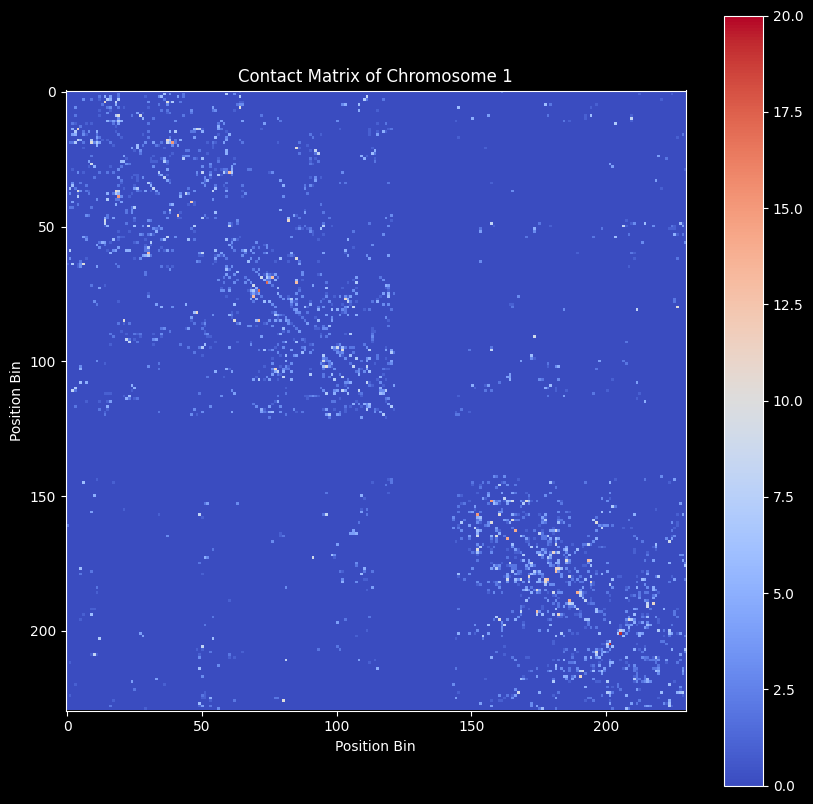

In [8]:
import matplotlib.pyplot as plt

# Hela_chr1_matrices[4] = apply_adjacent_smoothing(Hela_chr1_matrices[4], window_size=1)

def visualize(matrix, vmax) -> None:
    plt.figure(figsize=(10, 10))
    plt.imshow(matrix, cmap='coolwarm', interpolation='none', vmin=0, vmax=vmax)
    plt.colorbar()
    plt.title('Contact Matrix of Chromosome 1')
    plt.xlabel('Position Bin')
    plt.ylabel('Position Bin')
    plt.show()

visualize(Hela_chr1_matrices[4], 20)

In [9]:
def apply_adjacent_smoothing(matrix):
    # Create an output matrix to store the averages
    smoothed_matrix = np.zeros_like(matrix)
    
    # Get the number of rows and columns in the matrix
    rows, cols = matrix.shape
    
    for i in range(rows):
        for j in range(cols):
            # Define the boundaries of the window
            i_min = max(i - 1, 0)
            i_max = min(i + 1, rows - 1)
            j_min = max(j - 1, 0)
            j_max = min(j + 1, cols - 1)
            
            # Extract the window
            window = matrix[i_min:i_max+1, j_min:j_max+1]
            
            # Calculate the average of the window
            smoothed_matrix[i, j] = np.mean(window)
    
    return smoothed_matrix

smoothed_GM12878 = [apply_adjacent_smoothing(matrix) for matrix in GM12878_chr1_matrices]
smoothed_HAP1 = [apply_adjacent_smoothing(matrix) for matrix in HAP1_chr1_matrices]
smoothed_Hela = [apply_adjacent_smoothing(matrix) for matrix in Hela_chr1_matrices]
smoothed_K562 = [apply_adjacent_smoothing(matrix) for matrix in K562_chr1_matrices]

In [10]:
import statistics

def find_average(contact_matrices):
    average_list = []
    for matrix in contact_matrices:
        sum = 0
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                sum += matrix[i][j]
        avg = sum / (matrix.shape[0] * matrix.shape[1])
        average_list.append(avg)
    return average_list

def find_average_instance(matrix):
    sum = 0
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            sum += matrix[i][j]
    return sum / (matrix.shape[0] * matrix.shape[1])

def matrix_avg_stats(average_list):
    avg = statistics.mean(average_list)
    sd = statistics.stdev(average_list)
    minimum = min(average_list)
    maximum = max(average_list)
    n = len(average_list)
    return {"average": avg, "standard deviation": sd, "minimum": minimum, "maximum": maximum, "count": n}

average_GM12878 = find_average(GM12878_chr1_matrices)

average_stats_GM12878 = matrix_avg_stats(average_GM12878)
print(average_GM12878)
print(average_stats_GM12878)

[0.001890359168241966, 0.006767485822306238, 0.003667296786389414, 0.0020037807183364838, 0.0028733459357277885, 0.0029111531190926278, 0.0024952741020793953, 0.00279773156899811, 0.0023062381852551983, 0.005482041587901701, 0.0014744801512287335, 0.0028733459357277885, 0.00555765595463138, 0.0052173913043478265, 0.01058601134215501, 0.004536862003780718, 0.0031379962192816637, 0.0029867674858223064, 0.003175803402646503, 0.003667296786389414, 0.0021172022684310017, 0.006427221172022685, 0.0032514177693761816, 0.001776937618147448]
{'average': 0.003749212350346566, 'standard deviation': 0.002070954773928221, 'minimum': 0.0014744801512287335, 'maximum': 0.01058601134215501, 'count': 24}


In [11]:
average_HAP1 = find_average(HAP1_chr1_matrices)

average_stats_HAP1 = matrix_avg_stats(average_HAP1)

In [12]:
average_Hela = find_average(Hela_chr1_matrices)
average_stats_Hela = matrix_avg_stats(average_Hela)

In [13]:
average_K562 = find_average(K562_chr1_matrices)
average_stats_K562 = matrix_avg_stats(average_K562)

In [14]:
from scipy import stats

# Perform t-test for GM12878 and HAP1
t_statistic_GM12878_HAP1, p_value_GM12878_HAP1 = stats.ttest_ind(average_GM12878, average_HAP1)
# Perform t-test for GM12878 and Hela
t_statistic_GM12878_Hela, p_value_GM12878_Hela = stats.ttest_ind(average_GM12878, average_Hela)
# Perform t-test for GM12878 and K562
t_statistic_GM12878_K562, p_value_GM12878_K562 = stats.ttest_ind(average_GM12878, average_K562)
# Perform t-test for HAP1 and Hela
t_statistic_HAP1_Hela, p_value_HAP1_Hela = stats.ttest_ind(average_HAP1, average_Hela)
# Perform t-test for HAP1 and K562
t_statistic_HAP1_K562, p_value_HAP1_K562 = stats.ttest_ind(average_HAP1, average_K562)
# Perform t-test for Hela and K562
t_statistic_Hela_K562, p_value_Hela_K562 = stats.ttest_ind(average_Hela, average_K562)
# Print the t-statistics and p-values
print("GM12878 vs HAP1: T-statistic =", t_statistic_GM12878_HAP1, "P-value =", p_value_GM12878_HAP1)
print("GM12878 vs Hela: T-statistic =", t_statistic_GM12878_Hela, "P-value =", p_value_GM12878_Hela)
print("GM12878 vs K562: T-statistic =", t_statistic_GM12878_K562, "P-value =", p_value_GM12878_K562)
print("HAP1 vs Hela: T-statistic =", t_statistic_HAP1_Hela, "P-value =", p_value_HAP1_Hela)
print("HAP1 vs K562: T-statistic =", t_statistic_HAP1_K562, "P-value =", p_value_HAP1_K562)
print("Hela vs K562: T-statistic =", t_statistic_Hela_K562, "P-value =", p_value_Hela_K562)

GM12878 vs HAP1: T-statistic = -2.533753589850136 P-value = 0.011446438062502175
GM12878 vs Hela: T-statistic = -3.6299825357294098 P-value = 0.00029211964466242514
GM12878 vs K562: T-statistic = -1.4574767556633923 P-value = 0.14945659928961283
HAP1 vs Hela: T-statistic = -7.95207075906695 P-value = 2.735844598623959e-15
HAP1 vs K562: T-statistic = 2.922163951302446 P-value = 0.003557332208792386
Hela vs K562: T-statistic = 4.583568279850621 P-value = 4.9111249453181604e-06


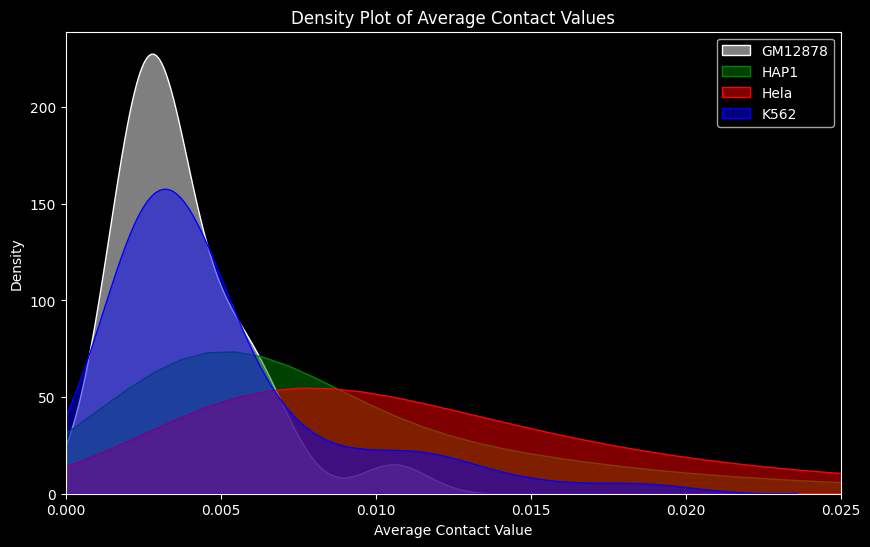

In [15]:
import seaborn as sns
data = [average_GM12878, average_HAP1, average_Hela, average_K562]
colors = ['white', 'green', 'red', 'blue']
labels = ['GM12878', 'HAP1', 'Hela', 'K562']

# Create the density plot
plt.figure(figsize=(10, 6))
for values, color, label in zip(data, colors, labels):
    sns.kdeplot(values, color=color, label=label, fill=True, alpha=0.5)

# Fix the x-axis range
plt.xlim(0, 0.025)

# Add titles and labels
plt.title('Density Plot of Average Contact Values')
plt.xlabel('Average Contact Value')
plt.ylabel('Density')
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [16]:
# Function to parse the text file
def parse_file(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction'])
    total_sum = data['interaction'].sum()
    cis_contacts = data[data['chr1'] == data['chr2']]['interaction'].sum()
    trans_contacts = data[data['chr1'] != data['chr2']]['interaction'].sum()
    # Calculate the cis:trans ratio
    if trans_contacts == 0:
        cis_trans_ratio = float('inf')  # To handle division by zero
    else:
        cis_trans_ratio = cis_contacts / trans_contacts

    if total_sum >= 1000 and cis_trans_ratio >= 1:
        return data
    print(f"SKIPPED {file_path}")
    return None

# Function to load data into contact matrices for all chromosomes
def load_chromosome_matrices(data, max_bin):
    # Initialize matrices for each chromosome
    chr_matrices = {chr: np.zeros((size, size)) for chr, size in max_bin.items()}
    
    # Populate the matrices with interaction data
    for _, row in data.iterrows():
        chr1 = row['chr1']
        chr2 = row['chr2']
        pos1 = row['pos1'] // 1000000
        pos2 = row['pos2'] // 1000000
        interaction = row['interaction']
        
        if chr1 in chr_matrices and chr2 in chr_matrices:
            size1 = chr_matrices[chr1].shape[0]
            size2 = chr_matrices[chr2].shape[0]
            if pos1 < size1 and pos2 < size2:
                chr_matrices[chr1][pos1, pos2] += interaction
                if chr1 == chr2:
                    chr_matrices[chr2][pos2, pos1] += interaction  # Ensure symmetry

    # Convert dictionary to list ordered by chromosome
    ordered_matrices = [chr_matrices[chr] for chr in sorted(max_bin.keys())]
    return ordered_matrices

# Function to load matrices for all chromosomes from a directory
def load_all_chromosome_matrices(directory, max_bin):
    all_chr_matrices = []
    filepaths = []
    
    for filename in tqdm(os.listdir(directory), desc="Processing files"):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            data = parse_file(filepath)
            if data is not None:
                chr_matrices = load_chromosome_matrices(data, max_bin)
                all_chr_matrices.append(chr_matrices)
                filepaths.append(filepath)
            else:
                print(f"Data is None for file {filepath}, skipping.")
    
    return all_chr_matrices, filepaths



In [17]:
# Compute matrices for each cell type separately
GM12878_cells = load_all_chromosome_matrices(directories['GM12878'], max_bin)[0]
HAP1_cells = load_all_chromosome_matrices(directories['HAP1'], max_bin)[0]
Hela_cells = load_all_chromosome_matrices(directories['Hela'], max_bin)[0]
K562_cells = load_all_chromosome_matrices(directories['K562'], max_bin)[0]

Processing files: 100%|██████████| 48/48 [00:03<00:00, 13.09it/s]


In [18]:
# Function to flatten and concatenate matrices of different shapes
def flatten_and_concatenate_matrices(matrices):
    flattened_vectors = [matrix.flatten() for matrix in matrices]
    concatenated_vector = np.concatenate(flattened_vectors)
    return concatenated_vector

# Function to prepare data for UMAP
def prepare_data_for_umap(cells):
    concatenated_vectors = [flatten_and_concatenate_matrices(cell) for cell in cells]
    return np.array(concatenated_vectors)

In [19]:
# Prepare data for UMAP
GM12878_vectors = prepare_data_for_umap(GM12878_cells)
HAP1_vectors = prepare_data_for_umap(HAP1_cells)
Hela_vectors = prepare_data_for_umap(Hela_cells)
K562_vectors = prepare_data_for_umap(K562_cells)

In [20]:
# Combine all data for UMAP
all_vectors = np.vstack([GM12878_vectors, HAP1_vectors, Hela_vectors, K562_vectors])

In [57]:
labels = (
    [1] * len(GM12878_vectors) +
    [2] * len(HAP1_vectors) +
    [3] * len(Hela_vectors) +
    [4] * len(K562_vectors)
)
labels = np.array(labels)

In [21]:
from umap import UMAP
# Configure UMAP hyperparameters
reducer = UMAP(n_neighbors=5, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=3, # default 2, The dimension of the space to embed into.
               metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1, # default 1.0, The initial learning rate for the embedding optimization.
               init='spectral', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0, # default 0.1, The effective minimum distance between embedded points.
               random_state=10
              )
transformed_data = reducer.fit_transform(all_vectors)

/Users/rogersyang/Documents/PhD Application/Research/3D DNA Structure Heterogeneity/DNA3D/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [33]:
def chart(X, y):
    #--------------------------------------------------------------------------#
    # This section is not mandatory as its purpose is to sort the data by label 
    # so, we can maintain consistent colors for digits across multiple graphs
    
    # Concatenate X and y arrays
    arr_concat = np.concatenate((X, y.reshape(y.shape[0], 1)), axis=1)
    # Create a Pandas dataframe using the above array
    df = pd.DataFrame(arr_concat, columns=['x', 'y', 'z', 'label'])
    # Convert label data type from float to integer
    df['label'] = df['label'].astype(int)
    # Finally, sort the dataframe by label
    df.sort_values(by='label', axis=0, ascending=True, inplace=True)
    
    # Create a 3D graph
    fig = px.scatter_3d(df, x='x', y='y', z='z', color=df['label'].astype(str), height=900, width=950)

    # Update chart looks
    fig.update_layout(showlegend=True,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=-1.4, z=0.5)),
                      margin=dict(l=0, r=0, b=0, t=0),
                      scene=dict(xaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='#f0f0f0',
                                            title_font=dict(size=10),
                                            tickfont=dict(size=10)),
                                 yaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='#f0f0f0',
                                            title_font=dict(size=10),
                                            tickfont=dict(size=10)),
                                 zaxis=dict(backgroundcolor='lightgrey',
                                            color='black', 
                                            gridcolor='#f0f0f0',
                                            title_font=dict(size=10),
                                            tickfont=dict(size=10))))
    # Update marker size
    fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))
    
    fig.show()

In [34]:
chart(transformed_data, labels)

Cluster labels for each cell: [1 2 1 ... 1 2 1]


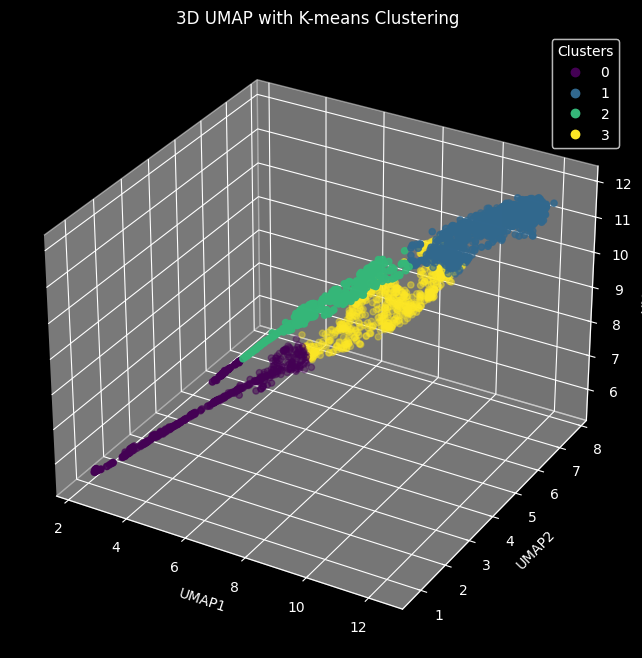

In [40]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

# Apply K-means clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=42, algorithm="lloyd")
kmeans.fit(transformed_data)
labels = kmeans.labels_

# Print the resulting labels
print("Cluster labels for each cell:", labels)

# Create a 3D scatter plot to visualize the clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with cluster labels as colors
scatter = ax.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], c=labels, cmap='viridis', marker='o')

# Set labels
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.set_title('3D UMAP with K-means Clustering')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

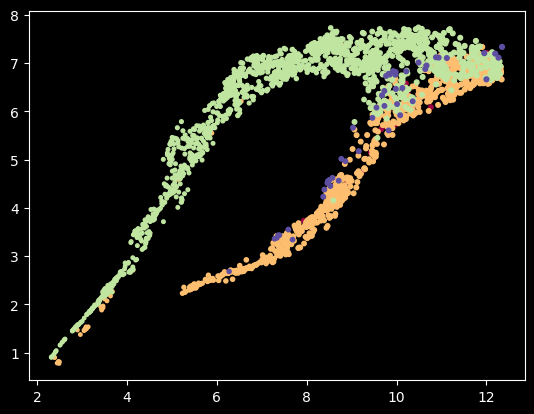

In [46]:
import matplotlib.pyplot as plt

plt.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2],
            c=labels, cmap='Spectral')
